In [289]:
import pandas as pd
pd.options.mode.chained_assignment = None 
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv('original_dataset.csv', low_memory = False, dtype = {'locality': str, 'postcode': str, 'property_subtype': str})
raw_df = df

In [290]:
df = df[['locality', 'postcode', 'property_subtype', 'price', 'rooms_number', 'area']]
regex = "(10|11|12)\d{2}"
df = df[df.postcode.str.match(regex, na=False)|df.locality.str.match(regex, na=False)]

In [291]:
df = df.drop(df[df['price'].isnull()].index)
df = df.drop(df[df['area'].isnull()].index)

df = df.drop(df[df['price'] == 'None'].index)
df = df.drop(df[df['price'] == '@0'].index)
df = df.drop(df[df['price'] == '1À000'].index)
df = df.drop(df[df['price'] == '2À000'].index)
df = df.drop(df[df['price'] == '3À000'].index)
df = df.drop(df[df['price'] == '23456789'].index)

df = df.drop(df[df['area'] == 'None'].index)
df = df.drop(df[df['area'] == 'Not specified'].index)

df = df.drop(df[df['locality'] == '1044'].index)
df = df.drop(df[df['locality'] == '1212'].index)

In [292]:
df['locality'] = df['locality'].str.upper()
df['property_subtype'] = df['property_subtype'].str.upper()

In [293]:
character_map = {
    'É' : 'E',
    '\(' : '', 
    '\)' : '', 
    '_':'-'
}
df.replace(character_map, inplace=True, regex=True)

In [294]:
conversions = {
    'FLAT-STUDIO':'FLAT',
    'SERVICE-FLAT':'FLAT'
}
df['property_subtype'] = df['property_subtype'].map(conversions).fillna(df['property_subtype'])

In [295]:
def extract_postcode(d): 
    return re.sub("((\d{4}){0,1})(([A-Za-z- ]+[0-9]{0,2}){0,1})", r'\2',d)
df['extracted_pc_from_loc'] = df[~df['locality'].isnull()]['locality'].apply(extract_postcode)
df['extracted_pc_from_pc'] = df[~df['postcode'].isnull()]['postcode'].apply(extract_postcode)

In [296]:
df['merged_postcode'] = df['extracted_pc_from_loc'].replace(np.nan, '') + df['extracted_pc_from_pc'].replace(np.nan, '')
def unmerge_postcode(d): 
    return re.sub("(\d{4}){0,1}(\d{4})$", r'\2', d)
df['unmerged_postcode'] = df[~df['merged_postcode'].isnull()]['merged_postcode'].apply(unmerge_postcode)

In [297]:
df = df.drop(['locality', 'postcode', 'extracted_pc_from_loc', 'extracted_pc_from_pc', 'merged_postcode'], axis=1, errors='ignore')

In [298]:
def clean_area(d): 
    return re.sub('^([0-9]+)( {0,}m{0,}²{0,})', r'\1',d)
df['area'] = df['area'].apply(clean_area)

In [299]:
df['area'] = pd.to_numeric(df['area'])

In [300]:
df = df.drop(df[df['area']>600].index)

In [301]:
def clean_price(d): 
    return re.sub("^(€{0,})(([0-9\,\.])+)(€{0,})$", r'\2',d)
df['price'] = df['price'].apply(clean_price)

In [302]:
character_map = {
    '\.' : '', 
    '\,' : ''
}
df.replace(character_map, inplace=True, regex=True)

In [303]:
df['price'] = pd.to_numeric(df['price'])
df['area'] = pd.to_numeric(df['area'])

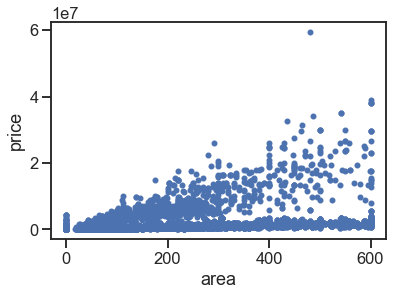

In [304]:
df.plot.scatter(x = 'area', y = 'price')

In [305]:
df = df.drop(df[df['price']==max(df['price'])].index)

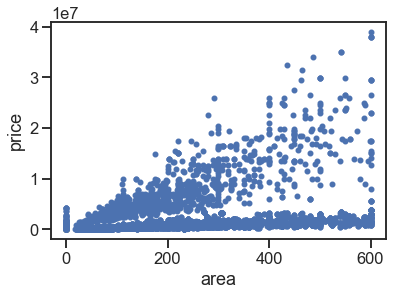

In [306]:
df.plot.scatter(x = 'area', y = 'price')

In [307]:
df['rooms_number'].unique()

array(['4', '2', '3', '7', '8', '5', '0', '6', '9', '10', '1', '11', '12',
       '20', '13', '28', '22', 'None', '60', '50', '40', '70', '30', '80',
       '00', '90', '100', '120', 'Not specified'], dtype=object)

In [308]:
df['rooms_number'] = pd.to_numeric(df['rooms_number'], errors='coerce')

In [309]:
df['rooms_number'].unique()

array([  4.,   2.,   3.,   7.,   8.,   5.,   0.,   6.,   9.,  10.,   1.,
        11.,  12.,  20.,  13.,  28.,  22.,  nan,  60.,  50.,  40.,  70.,
        30.,  80.,  90., 100., 120.])

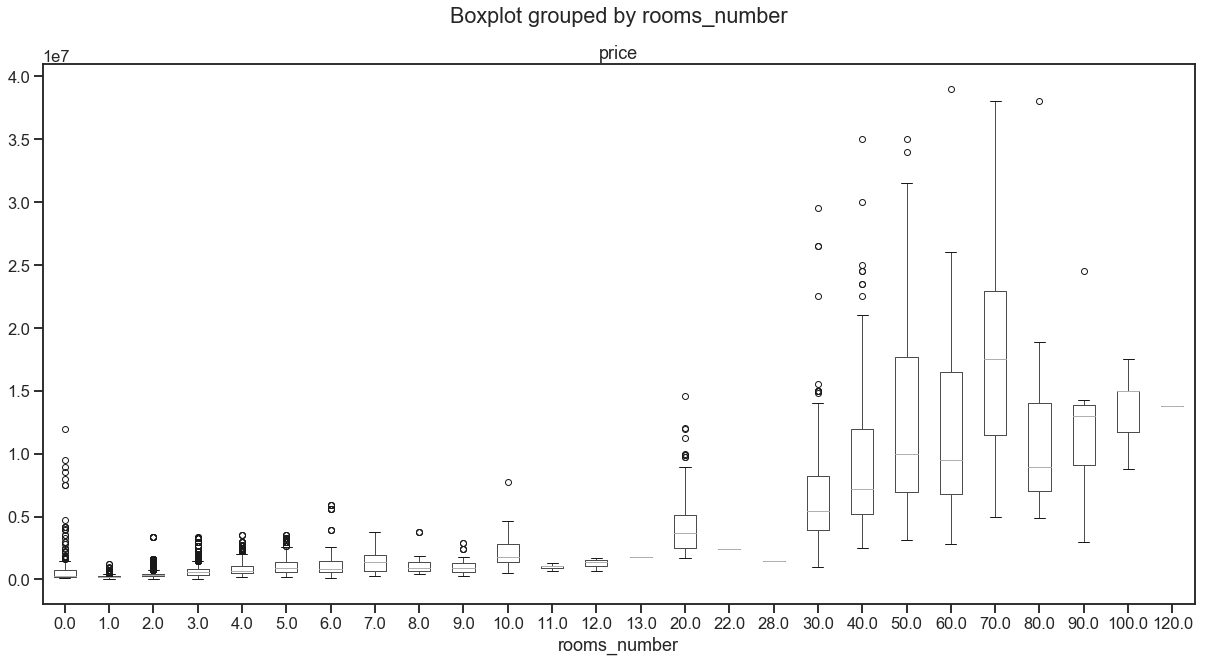

In [310]:
df.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

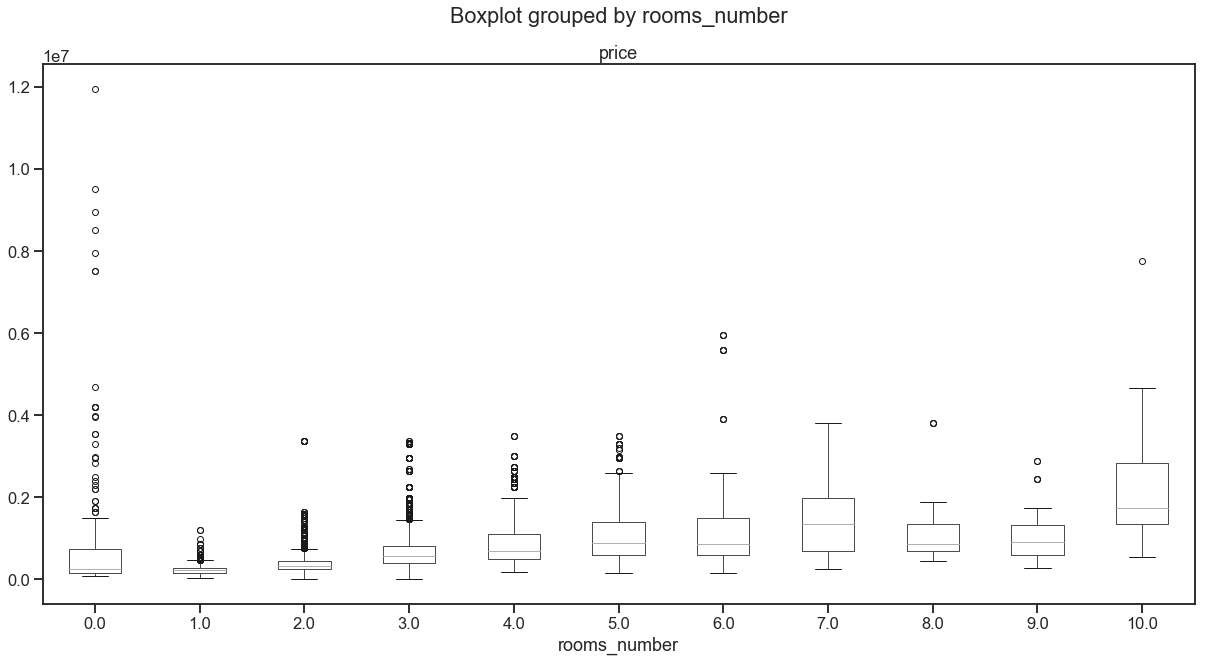

In [311]:
df_small_room = df[df['rooms_number']<11]
df_small_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

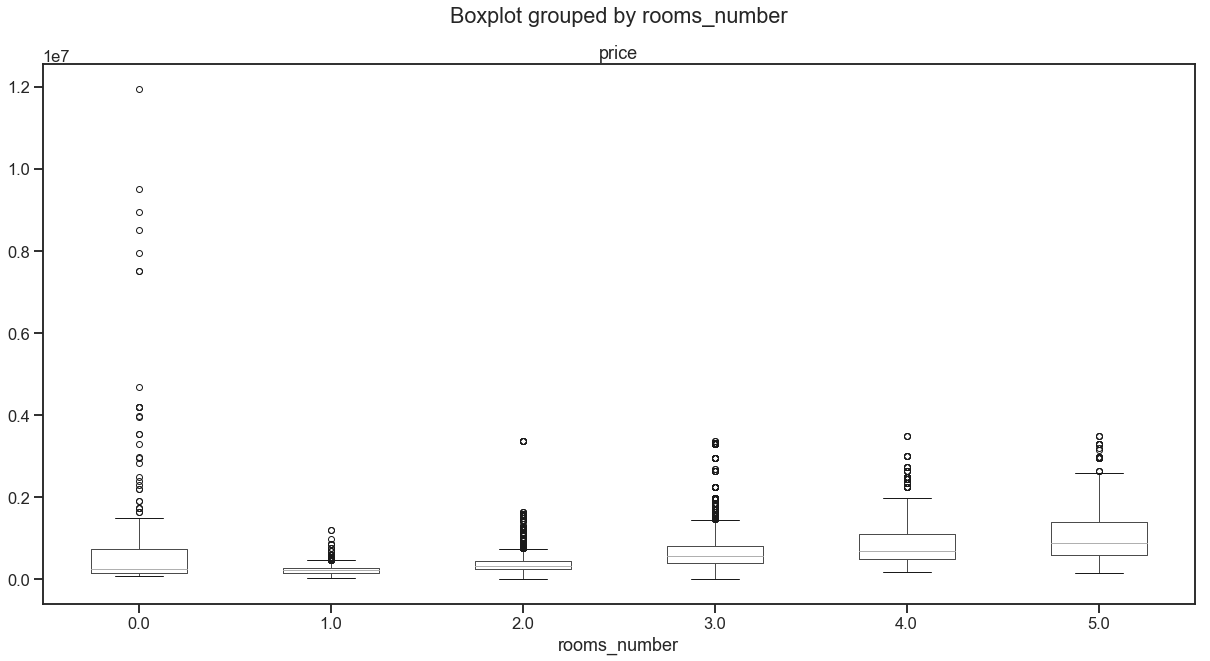

In [312]:
df_super_small_room = df[df['rooms_number']<6]
df_super_small_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

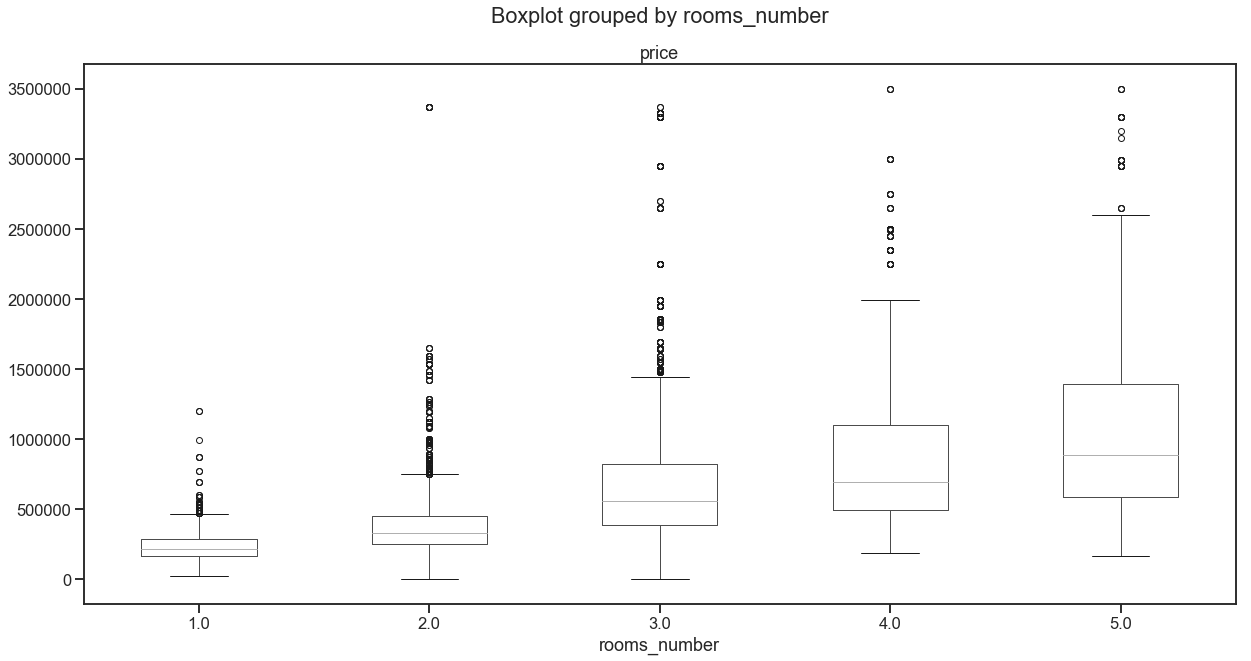

In [313]:
df_average_room = df_super_small_room[df_super_small_room['rooms_number']>0]
df_average_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

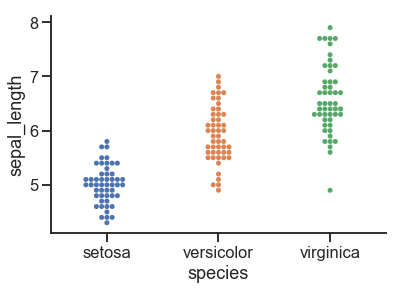

In [314]:
import seaborn as sns

sns.set(style='ticks', context='talk')
iris = sns.load_dataset('iris')

sns.swarmplot('species', 'sepal_length', data=iris)
sns.despine()

In [315]:
#sns.swarmplot('unmerged_postcode', 'price', data = df)

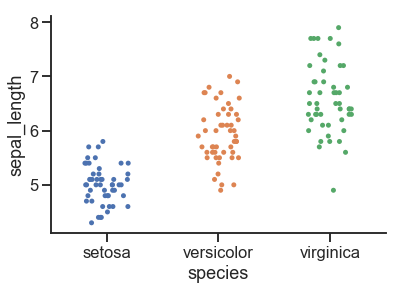

In [316]:
sns.stripplot('species', 'sepal_length', data=iris, jitter=0.2)
sns.despine()

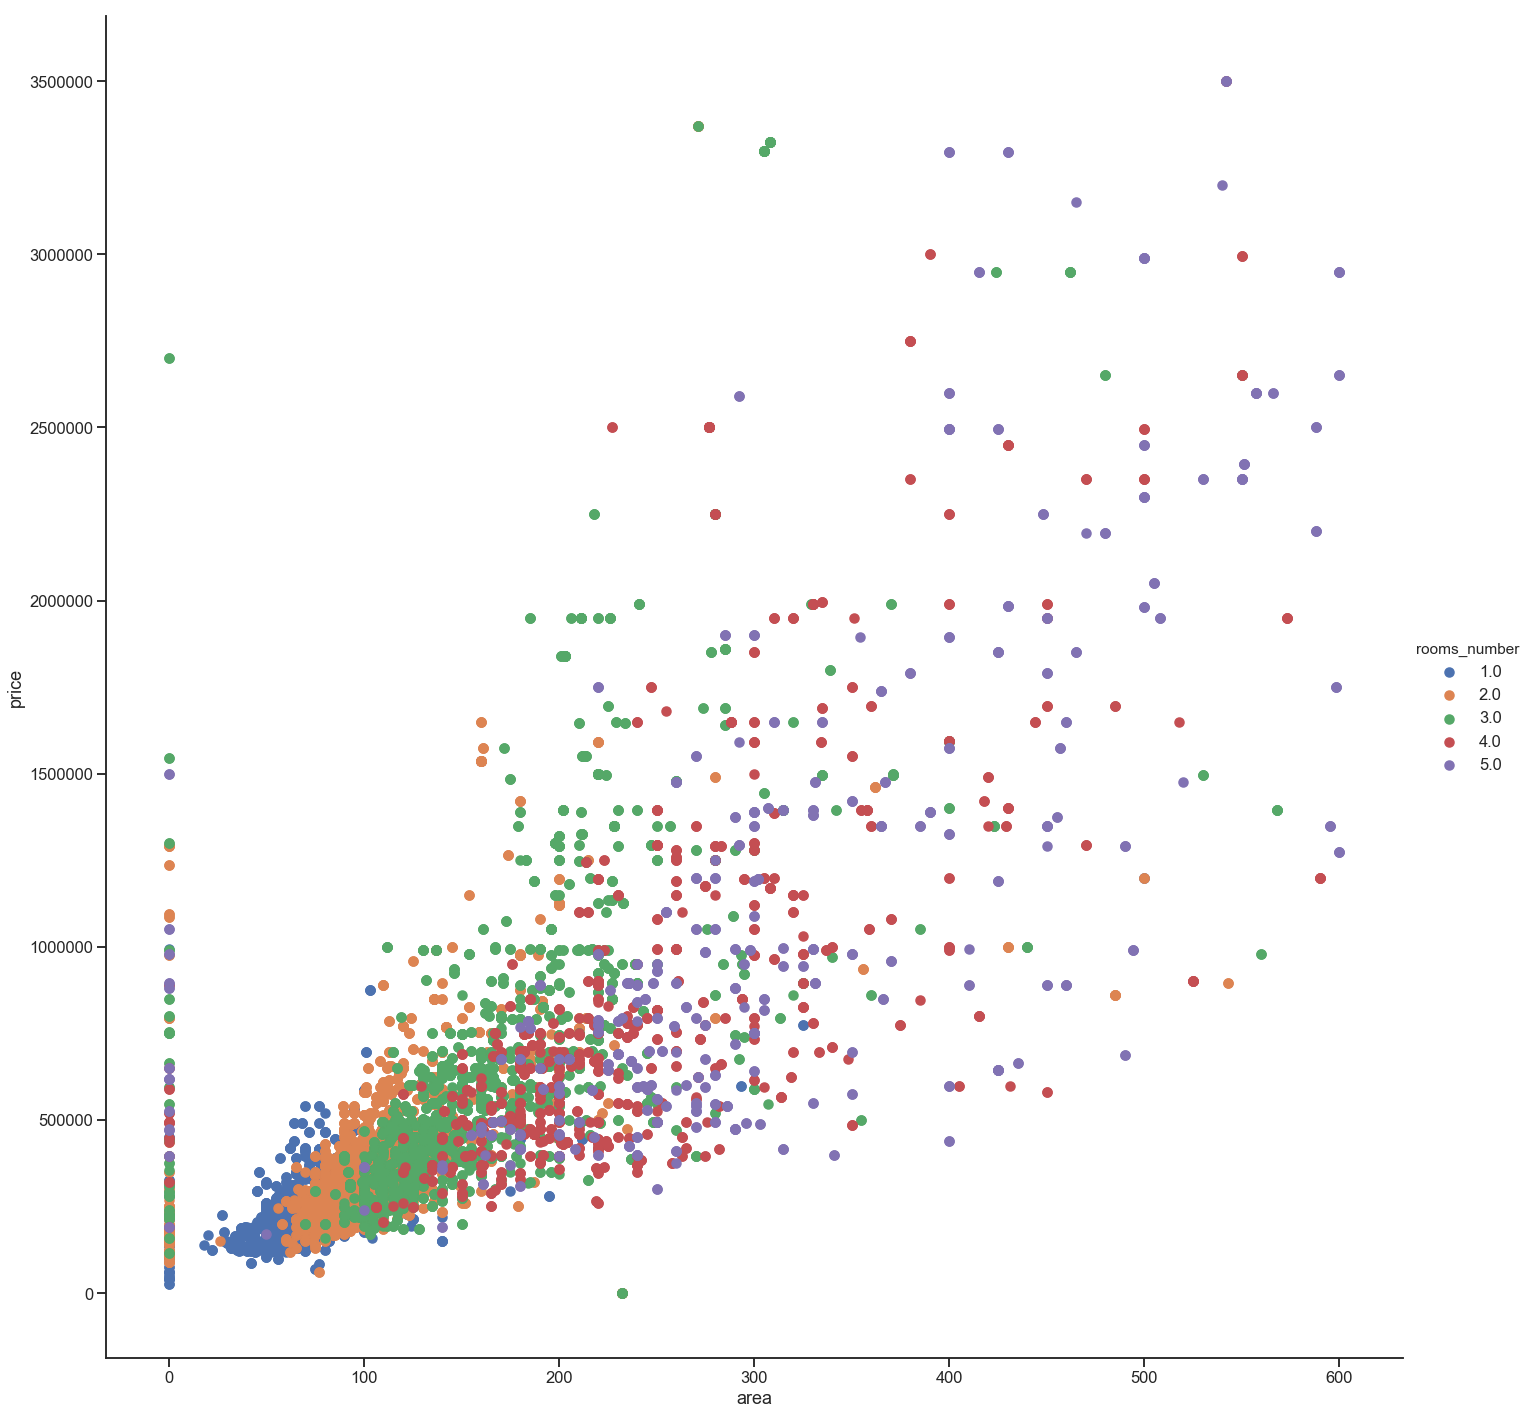

In [317]:
import seaborn as sns
fg = sns.FacetGrid(data=df_average_room, hue='rooms_number', height = 20, aspect=1)
fg.map(plt.scatter, 'area', 'price').add_legend()

In [326]:
df_pc = pd.read_csv('postcodes.csv')
df_original = df
df = df.rename(columns={'unmerged_postcode': 'postcode'})

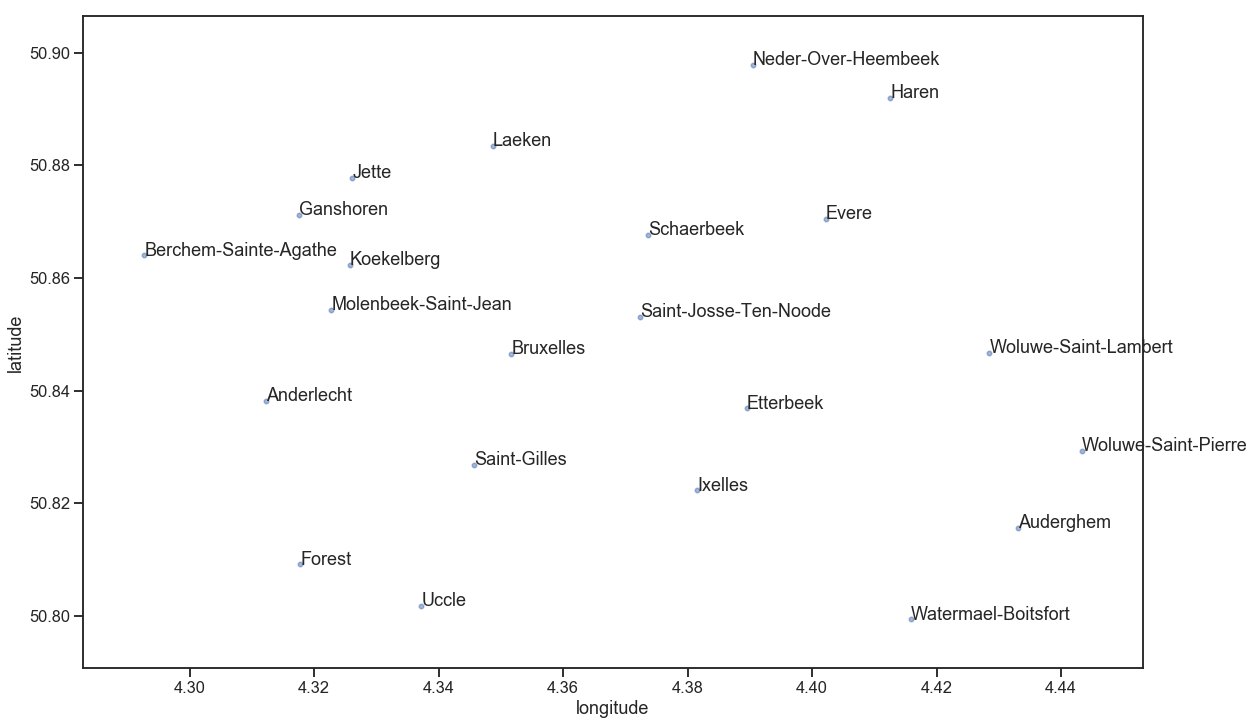

In [339]:
import pandas as pd 
from matplotlib import pyplot as plt 

ax = df_pc.plot.scatter(x='longitude', y='latitude', figsize=(19,12), alpha=0.5)
for i, txt in enumerate(df_pc.locality):
    ax.annotate(txt, (df_pc.longitude.iat[i],df_pc.latitude.iat[i]))
plt.show()

In [ ]:
#compter le nombres de values par categorie
#faire des boxplot par postcode
#faire les reglin 
#continuer les modèles prédictifs